# SchW-BERT-GAN 事前学習
Theorytabデータセットを使用
- 前処理済みのデータセットからバッチ生成器を作成
- ハイパーパラメータを記入した設定ファイルを作成
- ChordConditionalBertCoreモジュールの定義
- 事前学習フレームワークと事前学習モジュールの作成
- 事前学習の実行と結果の表示・保存

In [1]:
import os, time, math, json, random
import hickle as hkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import Dataset, DataLoader, random_split
from attrdict import AttrDict
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, grid_plot
from bundle import Bundle

current dir: /root/schwbert


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

input_dir = os.path.join(schwbert_dir, "data", "theorytab")
input_path = os.path.join(input_dir, "original.hkl")

output_base_dir = os.path.join(schwbert_dir, "model")
output_dir = os.path.join(output_base_dir, "theorytab")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# 前処理済みのtheorytabデータセットからバッチ生成器を作成
DataLoaderとDatasetの扱い方はQiitaを[参照](https://qiita.com/takurooo/items/e4c91c5d78059f92e76d)

その前にまずは前処理済みデータをロード

In [3]:
with Timer():
     bundle_list = hkl.load(input_path)
print(len(bundle_list))

310.557900
17396


DataLoaderへ渡すTheorytabDatasetを作成

In [4]:
class TheorytabDataset(Dataset):
    def __init__(self, bundles, include_meta=False):
        self.data = bundles
        self.data_num = len(bundles)
        self.include_meta = include_meta
    
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        melody = self.data[idx]['melody']
        chord = self.data[idx]['chord']
        
        if self.include_meta:
            meta = self.data[idx]['meta']
            return melody, chord, meta
        
        return melody, chord

In [5]:
dataset = TheorytabDataset(bundle_list, include_meta=True)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

動作確認

In [6]:
melody_batch, chord_batch, meta_batch = next(dataloader.__iter__())
print(melody_batch.type())
print(chord_batch.type())
print(meta_batch)

torch.LongTensor
torch.LongTensor
{'bars': tensor([16, 16]), 'beat_resolution': tensor([12, 12]), 'beats_in_bar': tensor([4, 4]), 'bpm': tensor([144,  88]), 'chord_is_ids': tensor([True, True]), 'chord_offset': tensor([48, 48]), 'chord_pitch_pad': tensor([4096, 4096]), 'chord_pitch_range': [tensor([0, 0]), tensor([12, 12])], 'chord_vocab_size': tensor([4097, 4097]), 'key': ['A minor', 'A minor'], 'melody_is_ids': tensor([True, True]), 'melody_offset': tensor([36, 36]), 'melody_pitch_mask': tensor([65, 65]), 'melody_pitch_pad': tensor([66, 66]), 'melody_pitch_range': [tensor([0, 0]), tensor([64, 64])], 'melody_pitch_rest': tensor([64, 64]), 'melody_vocab_size': tensor([67, 67]), 'original_bars': tensor([ 4, 10]), 'original_key': ['A minor', 'G minor'], 'path': ['z/zun/lunate-elf/verse_key.mid', 'e/eric-clapton/i-shot-the-sheriff/verse_key.mid'], 'range_for': tensor([ 4, 10]), 'range_from': tensor([0, 0])}


あ，辞書の中身もバッチ内で連結されるのね…

# ハイパーパラメータを記入した設定辞書を作成

In [7]:
rep = dataset[0]
rep_meta = AttrDict(rep[2])

In [66]:
config = {
    'step_num': rep[0].shape[0],
    'beat_resolution': rep_meta.beat_resolution,
    'beats_in_bar': rep_meta.beats_in_bar,
    'bar_num': rep_meta.bars,
    'melody_pitch_range': rep_meta.melody_pitch_range,
    'melody_mask_id': rep_meta.melody_pitch_mask,
    'melody_rest_id': rep_meta.melody_pitch_rest,
    'melody_pad_id': rep_meta.melody_pitch_pad,
    'melody_vocab_size': rep_meta.melody_vocab_size,
    'chord_pad_id': rep_meta.chord_pitch_pad,
    'chord_vocab_size': rep_meta.chord_vocab_size,
    'hidden_size': 24,
    'intermediate_size': 24 * 4,
    'attention_layer_num': 2,
    'attention_head_num': 4,
    'dropout_prob': 0.1,
    'adam_lr': 1e-5,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'pre_mnp_rate': 0.15,
    'pre_mnp_mask_rate': 0.80,
    'pre_mnp_random_rate': 0.10,
    'pre_mnp_keep_rate': 0.10,
}
config = AttrDict(config)
for item in config.items():
    print(f"{item[0]}: {item[1]}")

step_num: 768
beat_resolution: 12
beats_in_bar: 4
bar_num: 16
melody_pitch_range: (0, 64)
melody_mask_id: 65
melody_rest_id: 64
melody_pad_id: 66
melody_vocab_size: 67
chord_pad_id: 4096
chord_vocab_size: 4097
hidden_size: 24
intermediate_size: 96
attention_layer_num: 2
attention_head_num: 4
dropout_prob: 0.1
adam_lr: 1e-05
adam_beta1: 0.9
adam_beta2: 0.999
pre_mnp_rate: 0.15
pre_mnp_mask_rate: 0.8
pre_mnp_random_rate: 0.1
pre_mnp_keep_rate: 0.1


# ChordConditionalBertCoreの作成
事前学習を行い，他のタスク用モジュールへ連結するためのCoreモジュール  
コードは[ここ](https://nbviewer.jupyter.org/github/fuurin/pytorch_advanced/blob/master/Chapter8/8-2_bert_base.ipynb)を参照

実装するものはこれ  
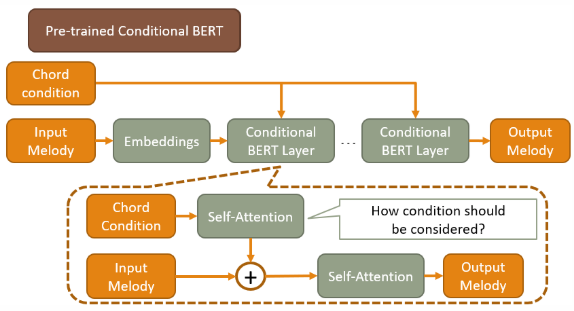

基本となるBERT Layerモジュールはこれ  
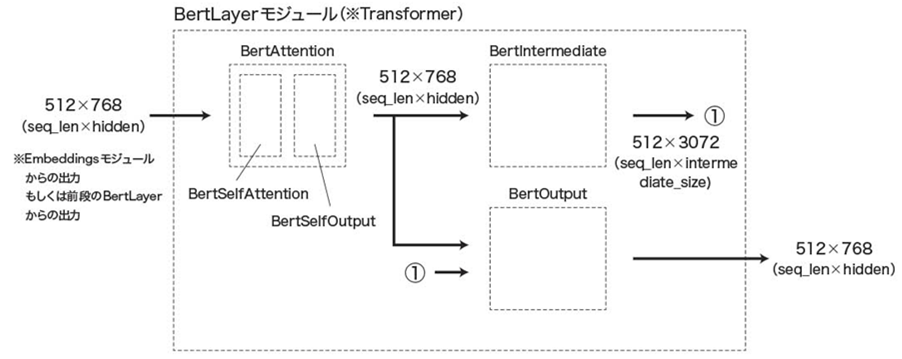

画像： 書籍「つくりながら学ぶ! PyTorchによる発展ディープラーニング」（小川雄太郎、マイナビ出版 、19/07/29)  
公式リポジトリ https://github.com/YutaroOgawa/pytorch_advanced

#### Conditional Bertにするための変更点
ChordConditionをBertAttentionに通した出力をAとする  
AとInputMelodyをBertOutputのような加算＋正規化モジュールへ送った出力をBとする  
BをBertAttentionへ送り，後は同じ  
なお，クラス分類用のPoolerは今回の生成タスクでは使用しないので実装しない  
代わりに小節ごとの情報をまとめるPoolerを作るか？
  
ChordConditionにもEmbedding欲しいかなぁ

## Embeddingsモジュールの実装
- Embeddings
    - MelodyEmbeddings
    - ChordEmbeddings
        - IDで渡ってこないので，EmbeddingsではなくDenseで実装

Embeddingsは意味のある区切りを与えることが多い模様  
それに倣って，音楽版のEmbeddingsは4つで行ってみよう！
- input_embedding: ピッチID/コードベクトルのEmbedding
- step_embedding: range(seq_len)を与えるEmbedding
- beat_embedding: 0から始まる拍番号を各ステップへ与える
- bar_embedding: 0から始まる小節番号を各ステップへ与える

とりあえず埋め込みは学習対象パラメータにする  
埋め込みベクトルのサイズは…  
一般的に語彙が多すぎるから圧縮するわけなんだけど，MIDIだとそんなに多くない  
ここは4, 12, 24, 48, 64辺りを試してみるか  
んで，事前学習が上手くいくかどうか，GANで生成する曲がよくなるかを見る  
一般的なメロディの音程は2オクターブ前後なので，まずは24で試してみるか

In [9]:
class MusicEmbeddings(nn.Module):
    def __init__(self, config, vocab_size, pad_id=0):
        super(MusicEmbeddings, self).__init__()
        
        # EmbeddingLayer: (入力の種類数, 組込ベクトルサイズ)
        # 48とかのIDを受け取ってone-hot vectorと解釈して組込ベクトルへ変換する
        self.hidden_size = config.hidden_size
        self.beat_res = config.beat_resolution
        self.step_num = config.step_num
        self.beat_num = config.beats_in_bar * config.bar_num
        self.bar_num = config.bar_num
        self.bar_step_num = config.beats_in_bar * self.beat_res
        
        self.input_embeddings = nn.Embedding(
            vocab_size,
            self.hidden_size, # 24
            padding_idx=pad_id
        )
        
        self.step_embeddings = nn.Embedding(
            self.step_num,   # 768
            self.hidden_size # 24
        )
        
        self.beat_embeddings = nn.Embedding(
            self.beat_num,   # 64
            self.hidden_size # 24
        )
        
        self.bar_embeddings = nn.Embedding(
            self.bar_num,    # 16
            self.hidden_size # 24 ここはむしろEmbeddingのほうが大きくなってしまっている...
        )
        
        self.norm = LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def add_fixed_embeddings(self, input_emb):
        # step ID -> ステップ埋め込みベクトル
        step_ids = torch.arange(self.step_num, dtype=torch.float32) # 0~767
        step_ids = step_ids.unsqueeze(0).expand(input_emb.shape[:-1]) # バッチ用の次元を追加
        step_ids = step_ids.to(input_emb.device)
        step_emb = self.step_embeddings(step_ids.type(torch.long))
        
        # beat ID -> 拍埋め込みベクトル
        # 同じ数がbeat_res個続くようにする
        beat_ids = torch.floor(step_ids.clone() / self.beat_res)
        beat_emb = self.beat_embeddings(beat_ids.type(torch.long))
        
        # bar ID -> 小節埋め込みベクトル
        # 同じ数がbar_step_num個続くようにする
        bar_ids = torch.floor(step_ids.clone() / self.bar_step_num)
        bar_emb = self.bar_embeddings(bar_ids.type(torch.long))
        
        # 4つの埋め込みベクトルを足し合わせる
        # (batch_size, step_num, hidden_size)
        embeddings = input_emb + step_emb + beat_emb + bar_emb
        
        return embeddings
    
    def post_layers(self, tensor):
        tensor = self.norm(tensor)
        tensor = self.dropout(tensor)
        return tensor
    
    def forward(self, input_ids):
        # input_ids: (batch_size, step_num)の文章中の単語ID列
        
        # input ID -> 入力埋め込みベクトル
        input_emb = self.input_embeddings(input_ids)
        
        # ステップ，拍，小節の埋め込みベクトルを加算
        embeddings = self.add_fixed_embeddings(input_emb)
                
        # 埋め込みベクトルを正規化 & Dropout
        embeddings = self.post_layers(embeddings)
        
        return embeddings

class MelodyEmbeddings(MusicEmbeddings):
    def __init__(self, config):
        super(MelodyEmbeddings, self).__init__(config, config.melody_vocab_size, config.melody_pad_id)

class ChordEmbeddings(MusicEmbeddings):
    def __init__(self, config):
        super(ChordEmbeddings, self).__init__(config, config.chord_vocab_size, config.chord_pad_id)

動作確認

In [10]:
melody_batch, chord_batch, _ = next(dataloader.__iter__())

print(melody_batch.shape)
print(chord_batch.shape)

melody_embeddings = MelodyEmbeddings(config)
chord_embeddings = ChordEmbeddings(config)

melody_emb = melody_embeddings(melody_batch)
chord_emb = chord_embeddings(chord_batch)

print("melody_emb shape:", melody_emb.shape)
print("chord_emb shape:", chord_emb.shape)

torch.Size([2, 768])
torch.Size([2, 768])
melody_emb shape: torch.Size([2, 768, 24])
chord_emb shape: torch.Size([2, 768, 24])


## ConditionalBertAttentionモジュールの実装
以下のサブネットワークを持つ
- ConditionalBertAttention: Conditionを考慮したSelf-Attentionを計算
    - Multi-Head: 1, 2, 4, 8, とりあえず4から試すか
    - ここでpadをかける
- BertIntermediate: Self-Attentionの出力を全結合層で処理
    - 全結合層の活性化関数にGELU（Gaussian error Linear Unit, 入力0付近の出力が滑らか)を使う
- BertOutput: BertAttentionとBertIntermediateの出力を足し算

### ConditionalBertAttentionモジュールの作成
次のサブモジュールからなる
- condition_attn(BertSelfAttention)
- conditioning(BertSelfConditioning, BertSelfOutputとほぼ同じ)
- attn(BertSelfAttention)
- output(BertOutput)

In [11]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        
        self.hidden_size = config.hidden_size # 24
        self.attention_head_num = config.attention_head_num # 4
        self.attention_head_size = self.hidden_size // self.attention_head_num # 6
        
        # Self-Attentionの特徴量を作成する全結合層
        self.query = nn.Linear(self.hidden_size, self.hidden_size)
        self.key = nn.Linear(self.hidden_size, self.hidden_size)
        self.value = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def separate_into_heads(self, single):
        # multi-head attention用にテンソルの形を変換
        # [batch, steps, hidden] -> [batch, head_num, steps, head_size]
        multi_shape = single.size()[:-1] + (self.attention_head_num, self.attention_head_size)
        multi = single.view(*multi_shape).permute(0, 2, 1, 3)
        return multi
    
    def extend_pad(self, pad, paded_value=-10000.0):
        # multi-head attention用にpadの形を(batch, 1, 1, step_num)にする
        extended_pad = pad.unsqueeze(1).unsqueeze(2) # multi-headに次元を対応
        extended_pad = (1.0 - extended_pad) * paded_value
        extended_pad = extended_pad.to(dtype=torch.float32)
        return extended_pad
    
    def marge_heads(self, multi):
        # multi-head attentionに分離したテンソルの形を元に戻す
        # [batch, head_num, steps, head_size] -> [batch, steps, hidden]
        multi = multi.permute(0, 2, 1, 3).contiguous()
        single_shape = multi.size()[:-2] + (self.hidden_size,)
        single = multi.view(*single_shape)
        return single
    
    def forward(self, hidden_states, pad, get_probs=False):
        
        # 入力を全結合層で特徴量変換(分岐前)
        marged_query = self.query(hidden_states)
        marged_key = self.key(hidden_states)
        marged_value = self.value(hidden_states)
        
        # multi-head Attentionとして分岐
        queries = self.separate_into_heads(marged_query)
        keyes = self.separate_into_heads(marged_key)
        values = self.separate_into_heads(marged_value)
        
        # 特徴量同士の類似度を求める
        scores = torch.matmul(queries, keyes.transpose(-1, -2))
        scores = scores / math.sqrt(self.attention_head_size) # Scaled Dot-Product Attention
        
        # マスクをかける
        # 足し算なのは，attention_padに0か-infが入っているため
        # -infはsoftmax正規化したときに0になる
        scores = scores + self.extend_pad(pad)
        
        # AttentionMapの正規化とドロップアウト
        probs = nn.Softmax(dim=-1)(scores)
        probs = self.dropout(probs)
        
        # Attenton Mapをvalueに掛け算
        contexts = torch.matmul(probs, values)
        
        # multi-head Attentionの出力を結合
        context = self.marge_heads(contexts)
        
        if get_probs:
            return context, probs
        else:
            return context

In [12]:
class BertSelfConditioning(nn.Module):
    def __init__(self, config):
        super(BertSelfConditioning, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def forward(self, hidden_states, condition_tensor):
        conditioned_states = self.dense(hidden_states + condition_tensor)
        conditioned_states = self.dropout(conditioned_states)
        conditioned_states = self.norm(conditioned_states)
        return conditioned_states

In [13]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.norm(hidden_states + input_tensor)
        return hidden_states

In [14]:
class ConditionalBertAttention(nn.Module):
    def __init__(self, config):
        super(ConditionalBertAttention, self).__init__()
        self.condition_attn = BertSelfAttention(config)
        self.conditioning = BertSelfConditioning(config)
        self.attn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, get_probs=False):
        
        if get_probs:
            condition, condition_probs = self.condition_attn(condition_tensor, condition_pad, get_probs)
            conditioned_tensor = self.conditioning(input_tensor, condition)
            output, probs = self.attn(conditioned_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor) # or conditioned_tensor?
            return output, probs, condition_probs
        else:
            condition = self.condition_attn(condition_tensor, condition_pad, get_probs)
            conditioned_tensor = self.conditioning(input_tensor, condition)
            output = self.attn(conditioned_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor) # or conditioned_tensor?
            return output

In [15]:
def make_pad(ids, pad_id):
    return (ids != pad_id).to(torch.float32)

動作確認

In [16]:
melody_batch, chord_batch, _ = next(dataloader.__iter__())

print(melody_batch.shape)
print(chord_batch.shape)

melody_pad = make_pad(melody_batch, config.melody_pad_id)
chord_pad = make_pad(chord_batch, config.chord_pad_id)

melody_embeddings = MelodyEmbeddings(config)
chord_embeddings = ChordEmbeddings(config)
attention = ConditionalBertAttention(config)

melody_emb = melody_embeddings(melody_batch)
chord_emb = chord_embeddings(chord_batch)

get_probs=True
if get_probs:
    output, probs, c_probs = attention(melody_emb, chord_emb, melody_pad, chord_pad, get_probs=get_probs)
    print("output shape:", output.shape)
    print("probs shape:", probs.shape)
    print("conditional probs shape:", c_probs.shape)
else:
    output = attention(melody_emb, chord_emb, melody_pad, chord_pad, get_probs=get_probs)
    print("output shape:", output.shape)

torch.Size([2, 768])
torch.Size([2, 768])
output shape: torch.Size([2, 768, 24])
probs shape: torch.Size([2, 4, 768, 768])
conditional probs shape: torch.Size([2, 4, 768, 768])


### BertIntermediateモジュールの実装

In [17]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [18]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu
    
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

### BertOutputモジュールの実装

In [19]:
class BertOutput(BertSelfOutput):
    def __init__(self, config):
        super(BertOutput, self).__init__(config)        
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)

### まとめてConditionalBertLayerモジュールの実装

In [20]:
class ConditionalBertLayer(nn.Module):
    def __init__(self, config):
        super(ConditionalBertLayer, self).__init__()
        
        self.attn = ConditionalBertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
    
    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, get_probs=False):
        if get_probs:
            output, probs, c_probs = self.attn(input_tensor, condition_tensor, input_pad, condition_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output, probs, c_probs
        else:
            output = self.attn(input_tensor, condition_tensor, input_pad, condition_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output

## ChordConditionalBertCoreの実装

In [21]:
class ChordConditionalBertCore(nn.Module):
    def __init__(self, config):
        super(ChordConditionalBertCore, self).__init__()
        self.config = config
        self.melody_embeddings = MelodyEmbeddings(config)
        self.chord_embeddings = ChordEmbeddings(config)
        self.melody_pad_id = config.melody_pad_id
        self.chord_pad_id = config.chord_pad_id
        attention_list = [ConditionalBertLayer(config) for _ in range(config.attention_layer_num)]
        self.attention_list = nn.ModuleList(attention_list) # これを挟まないとパラメータが学習されない
    
    def make_pad(self, ids, pad_id):
        return (ids != pad_id).to(torch.float32)

    def forward(self, inputs, get_all_outputs=False, get_probs=False):
        melody_tensor = inputs[0]
        chord_tensor = inputs[1]
        melody_pad = self.make_pad(melody_tensor, self.melody_pad_id)
        chord_pad = self.make_pad(chord_tensor, self.chord_pad_id)

        melody = self.melody_embeddings(melody_tensor)
        chord = self.chord_embeddings(chord_tensor)
        
        # self attentionをかけるループ
        all_outputs = []
        all_probs = []
        all_c_probs = []
        for attention in self.attention_list:
            if get_probs:
                melody, probs, c_probs = attention(melody, chord, melody_pad, chord_pad, get_probs=get_probs)
            else:
                melody = attention(melody, chord, melody_pad, chord_pad, get_probs=get_probs)
                
            # 12段すべての出力を見る場合
            if get_all_outputs:
                all_outputs.append(melody)
                if get_probs:
                    all_probs.append(probs)
                    all_c_probs.append(c_probs)
                
        # 最終段のAttentionのみ必要な場合
        if not get_all_outputs:
            all_outputs = melody
            if get_probs:
                all_probs = probs
                all_c_probs = c_probs
        
        if get_probs:
            return all_outputs, all_probs, all_c_probs
        else:
            return all_outputs

動作確認

In [22]:
batch = next(dataloader.__iter__())

print(melody_batch.shape)
print(chord_batch.shape)

core = ChordConditionalBertCore(config)

get_probs = True
get_all_outputs = True
if get_probs:
    output, probs, c_probs = core(batch, get_all_outputs=get_all_outputs, get_probs=get_probs)
    if get_all_outputs:
        print("output len:", len(output))
        print("probs len:", len(probs))
        print("conditional probs len:", len(c_probs))
    print("output shape:", (output[0] if get_all_outputs else output).shape)
    print("probs shape:", (probs[0] if get_all_outputs else probs).shape)
    print("conditional probs shape:", (c_probs[0] if get_all_outputs else c_probs).shape)
else:
    output = core(batch, get_all_outputs=get_all_outputs, get_probs=get_probs)
    if get_all_outputs:
        print("output len:", len(output))
    print("output shape:", (output[0] if get_all_outputs else output).shape)

torch.Size([2, 768])
torch.Size([2, 768])
output len: 2
probs len: 2
conditional probs len: 2
output shape: torch.Size([2, 768, 24])
probs shape: torch.Size([2, 4, 768, 768])
conditional probs shape: torch.Size([2, 4, 768, 768])


Coreのパラメータ数を確認してみる

In [23]:
trainable_params_num = sum(p.numel() for p in core.parameters() if p.requires_grad)
print("trainable params:", trainable_params_num)
# print(core)

trainable params: 160080


4段だと17万くらいしかパラメータなかったので12段にした  
それでも全然増えない．．．

# 事前学習フレームワークと各事前学習モジュールの作成

## 事前学習フレームワークの作成
事前学習フレームワークは以下の動作が主な役割である
- Core,DataLoader,事前学習クラスのリストを渡す
    - 入力データとラベルの作成
    - Coreと事前学習モジュールを連結
    - 入力データを連結モジュールへ与える
    - 出力とラベルからロスをBP

事前学習クラスは以下を持つ
- 入力データとラベルの作成関数
- 事前学習モジュールの定義関数
- 損失関数

In [24]:
class PreTrainingModel(nn.Module):
    def __init__(self, core, criterion, config):
        super(PreTrainingModel, self).__init__()
        self.core = core
        self.criterion = criterion
        self.config = config
        self.loss_dict = {'train': [], 'val': []}
        self.acc_dict = {'train': [], 'val': []}
    
    def set_device(self, device):
        self.to(device)
        self.device = device
        return self
    
    def get_loss(self, model_output, label):
        loss = self.criterion(model_output, label)
        return loss
    
    def get_acc(self, model_output, label):
        probs, preds = torch.max(outputs, dim=-1)
        ones, labels = torch.max(label, dim=-1)
        correct_num = torch.sum(preds == label)
        acc = correct_num.to(float) / label.size().numel()
        return acc.item()
    
    def forward(self, batch):
        data, label = self.get_data_and_label(batch)
        
        for i, item in enumerate(batch):
            if type(batch[i]) == torch.Tensor:
                batch[i] = batch[i].to(self.device)
        label = label.to(self.device)
        
        core_output = self.core(data)
        model_output = self.forward_specific_task(core_output)
        
        loss = self.get_loss(model_output, label)
        acc = self.get_acc(model_output, label)
        
        return loss, acc
    
    def forward_specific_task(self, core_output):
        raise NotImplementedError()
        
    def get_data_and_label(self, batch):
        raise NotImplementedError()

In [25]:
def pre_train(core, pre_training_models, dataloaders_dict, optimizer, epoch_num, report_period=50): 
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(1, epoch_num+1):
        print(f"----- Epoch {epoch} / {epoch_num} start -----")
        t_epoch_start = time.time()
        
        for model in pre_training_models:
            print(f"\n----- Pre-training task start -----")
            print(f"Pre-training model: {model.__class__.__name__}")
            t_model_start = time.time()
            
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                    print("Validating...")
                
                model_loss = 0.0
                model_acc = 0
                
                t_iter_start = time.time()
                for iteration, batch in enumerate(dataloaders_dict[phase], 1):
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        loss, acc = model(batch)
                        model_loss += loss.item()
                        model_acc += acc
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            if (iteration % report_period == 0):
                                print(f"Iteration {iteration} || \
                                        Loss: {loss.item():.4f} || \
                                        Acc: {acc:.4f} || \
                                        {time.time() - t_iter_start:.4f}[sec]"
                                )
                                t_iter_start = time.time()
                
                batch_num = len(dataloaders_dict[phase].dataset)
                model_loss = model_loss / batch_num
                model_acc = model_acc / batch_num
                model.loss_dict[phase].append(model_loss)
                model.acc_dict[phase].append(model_acc)
                
                print(f"Average result of {model.__class__.__name__}")
                print(f"Epoch {epoch}/{num_epochs} | {phase:^5} | Loss: {model_loss:.4f} | Acc: {model_acc:.4f}")
            
            print(f"Pre-training task finished in {time.time() - t_model_start:.4f}[sec]")
        
        epoch_duration = time.time() - t_epoch_start
        print(f"Epoch {epoch} / {epoch_num} finished in {epoch_duration:.4f}[sec]")
        remain_sec = epoch_duration * (epoch_num - epoch)
        print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
        
        ### エポックごとのモデルの保存

    return core, models

## 各事前学習クラスの作成
事前学習はひとまず3種類
- Masked Note Prediction (虫食い音符の穴埋め)
    - 1ステップごとではなく，音符一つごとMASKして穴埋め
    - 休符も1つの音符と数えるべき？
    - ランダムに入れ替えたり，そのままにしたりするのを1割ずつやる
- Bars Order Prediction (小節の順番を学習)
    - 全ての小節をバラバラにして元の楽曲を生成
    - 16 × 16の行列を出力させ，どの小節が何番目にあるべきかを推論
- (Chord) Condition Prediction (元のコード条件を出力メロディから推論)
    - chord ID を出力メロディから推論
    - Chordにカッコがついてるのは，テンポやジャンルといった条件が増えたときにも同様の事前学習をさせられるため

### MaskedNotePredictionの作成
音符単位でマスクしてマスクされている部分を推測する  
[MASK]トークンはファインチューニングの際には出現しないためミスマッチを作ってしまうという弱点がある．  
そこで，マスク対象となった単語を実際の[MASK]には，必ずしも置き換えないことにする．  
  
訓練データ生成器は推論に用いる全体の15%のトークンポジションをランダムに選ぶ．  
$i$番目のトークンが選ばれたとき，$i$番目のトークンを
- (1) 80%の確立で[MASK]に置き換える
- (2) 10%の確立で別のランダムな単語に置き換える
- (3) 10%の確立でそのままのトークンにしておく
    
そして，$i$番目のトークン$T_i$はオリジナルのトークンの推測に使用され，cross entropy lossで損失を得る  
  
衝撃の事実: 事前学習用のデータは固定で，イテレーションの度にマスクされる場所が変更されるわけではなかった  
今回扱うデータは自然言語並みに多様性があるわけではないのでイテレーションの度に変更するようにしてみる

とりあえず全結合2段でMNPしてみよう

In [67]:
class MaskedNotePrediction(PreTrainingModel):
    def __init__(self, core, config, include_rest=True):
        super(MaskedNotePrediction, self).__init__(core, nn.CrossEntropyLoss(), config)
        self.include_rest = include_rest
        self.target_rate = config.pre_mnp_rate
        self.mask_rate = config.pre_mnp_mask_rate
        self.random_rate = config.pre_mnp_random_rate
        self.keep_rate = config.pre_mnp_keep_rate
        
        self.melody_vocab_size = config.melody_vocab_size
        self.mask_id = config.melody_mask_id
        self.rest_id = config.melody_rest_id
        self.pad_id = config.melody_pad_id
        
        self.melody_pitches = list(range(*config.melody_pitch_range))
        if include_rest:
            self.melody_pitches.append(self.rest_id)
        
        self.dense_1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.act_1 = gelu
        self.norm_1 = LayerNorm(config.hidden_size, eps=1e-12)
        self.dense_2 = nn.Linear(config.hidden_size, config.melody_vocab_size)
        self.act_2 = gelu
        self.norm_2 = LayerNorm(config.melody_vocab_size, eps=1e-12)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def forward_specific_task(self, core_output):
        # ここでloss計算対象ステップを絞る．
        # core_outputはすでに周囲の情報を考慮しており，
        # 以降のDenseではステップごとに同じ処理が行われるため，
        # targetでない入力を使う必要がない
        # metaのtarget_note_positionsに入れても仕方ないか…
        output = self.gather(core_output, target_note_positions, target_note_weights)
        output = self.dense_1(output)
        output = self.act_1(output)
        output = self.norm_1(output)
        output = self.dense_2(output)
        output = self.act_2(output)
        output = self.norm_2(output)
        output = self.softmax(output)
        return output
    
    def get_data_and_label(self, batch):
        labels = []
        # 音符の範囲情報をmetaにcacheしておきつつ，各範囲の中からランダムでマスクをかける
        for melody, _, meta in zip(batch):
            if not 'melody_note_areas' in meta.keys():
                note_areas = []
                last_pitch = None
                for step, pitch in enumerate(melody):
                    if (pitch in pitch_range) or (self.include_rest and pitch == self.rest_id):
                        if last_pitch != pitch:
                            note_areas.append([])
                        note_areas[-1].append(step)
                        last_pitch = pitch
                note_areas = np.array(note_areas)
                meta['melody_note_areas'] = note_areas
            else:
                note_areas = meta['melody_note_areas']
            
            note_num = len(note_areas)
            target_num = int(note_num * self.target_rate)
            random_num = int(target_num * self.random_rate)
            keep_num = int(target_num * self.keep_rate)
            masked_num = target_num - random_num - keep_num
            
            target_note_ids = random.sample(range(note_num), target_num)
            masked_note_ids = target_note_ids[:masked_num]
            random_note_ids = target_note_ids[masked_num:masked_num+random_num]
            
            target_note_positions = note_areas[target_note_ids] ### どっかしらに保存＋padding処理
            target_note_positions.ravel()
            
            # modelの出力がone-hotになるため, labelはone-hot
            label_ids = melody[target_note_positions]
            label_one_hots = torch.eye(self.melody_vocab_size)[label_ids]
            labels.append(label_one_hots.to(self.device))
            
            # mask対象の音符をmaskにする
            masked_note_positions = note_areas[masked_note_ids]
            masked_note_positions.ravel()
            melody[masked_note_positions] = self.mask_id
            
            # random対象の音符をランダムに入れ替え
            for random_note_id in random_note_ids:
                melody[note_areas[random_note_id]] = random.choice(self.melody_pitches)
            
        return batch, labels, target_positions, target_weights

動作確認

In [ ]:
batch = next(dataloader.__iter__())
mnp = MaskedNotePrediction(core, config)
batch, labels, target_positions, target_weights = mnp.get_data_and_label(batch)

### BarsOrderPredictionの作成

### ConditionPredictionの作成

# 事前学習の実行と結果の表示・保存

データの分割

In [140]:
batch_size = 2
train_rate = 0.8
val_rate = 0.15

all_size = len(dataset)
train_size = int(samples_num * train_rate)
val_size = int(samples_num * val_rate)
test_size = all_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=1)
}
print('train data size:', len(dataloaders_dict['train'].dataset))
print('val data size:', len(dataloaders_dict['val'].dataset))
print('test data size:', len(dataloaders_dict['test'].dataset))

train data size: 13916
val data size: 2609
test data size: 871


In [141]:
multi_gpu = False
device = torch.device('cuda:2')

multi_gpu = multi_gpu and (device == 'cuda')

core = ChordConditionalBertCore(config).to(device)
pre_training_models = [
    MaskedNotePrediction(core, config).set_device(device),
    # BarsOrderPrediction(core, config).set_device(device),
    # ConditionPrediction(core, config).set_device(device),
]

if multi_gpu:
    os.environ['CUDA_VISIBLE_DEVICES']=2,3
    pre_training_models = [torch.nn.DataParallel(model) for model in pre_training_models]

optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': config.adam_lr} for model in pre_training_models
], betas = (config.adam_beta1, config.adam_beta2))

print("Network settings completed")

ネットワーク設定完了


In [142]:
epoch_num = 10
core_trained, models_trained = pre_train(
    core=core,
    pre_training_models=pre_training_models,
    dataloaders_dict=dataloaders_dict,
    optimizer=optimizer,
    epoch_num=epoch_num,
    report_period=(train_size // batch_size) // 10
)

----- Epoch 1 / 10 start -----

----- Pre-training task start -----
Pre-training model: MaskedNotePrediction
> <ipython-input-133-7e0f1b3f7c36>(33)forward()
-> loss = self.criterion(model_output, label)


(Pdb)  ll


 21  	    def forward(self, batch):
 22  	        data, label = self.get_data_and_label(batch)
 23  	
 24  	        for i, item in enumerate(batch):
 25  	            if type(batch[i]) == torch.Tensor:
 26  	                batch[i] = batch[i].to(self.device)
 27  	        label = label.to(self.device)
 28  	
 29  	        core_output = self.core(data)
 30  	        model_output = self.forward_specific_task(core_output)
 31  	
 32  	        import pdb; pdb.set_trace()
 33  ->	        loss = self.criterion(model_output, label)
 34  	        acc = self.get_acc(model_output, label)
 35  	
 36  	        return loss, acc


(Pdb)  model_output.shape


torch.Size([2, 768, 67])


(Pdb)  model_output[0][0][0]


tensor(0.0050, device='cuda:2', grad_fn=<SelectBackward>)


(Pdb)  model_output[0][0]


tensor([0.0050, 0.0051, 0.0040, 0.0248, 0.0065, 0.0400, 0.0146, 0.0105, 0.0076,
        0.0123, 0.0029, 0.0091, 0.0030, 0.0063, 0.0211, 0.0164, 0.0029, 0.0052,
        0.0040, 0.0037, 0.0041, 0.0095, 0.0030, 0.0087, 0.0029, 0.0029, 0.0731,
        0.0074, 0.0037, 0.0065, 0.0029, 0.0118, 0.0076, 0.0029, 0.0345, 0.0072,
        0.0029, 0.0128, 0.0043, 0.0030, 0.0267, 0.0029, 0.0038, 0.0032, 0.0033,
        0.0848, 0.0029, 0.0032, 0.0271, 0.1274, 0.0099, 0.0029, 0.0289, 0.0069,
        0.0066, 0.0036, 0.0029, 0.0104, 0.1832, 0.0111, 0.0029, 0.0031, 0.0032,
        0.0029, 0.0036, 0.0059, 0.0100], device='cuda:2',
       grad_fn=<SelectBackward>)


(Pdb)  model_output[0][0].sum()


tensor(1., device='cuda:2', grad_fn=<SumBackward0>)


(Pdb)  torch.max(model_output, dim=-1)


torch.return_types.max(
values=tensor([[0.1832, 0.2206, 0.3531,  ..., 0.2821, 0.2921, 0.0806],
        [0.1426, 0.1530, 0.2940,  ..., 0.2949, 0.5218, 0.0937]],
       device='cuda:2', grad_fn=<MaxBackward0>),
indices=tensor([[58, 49, 49,  ..., 45, 45, 28],
        [34, 34, 34,  ..., 45, 45, 20]], device='cuda:2'))


(Pdb)  torch.max(model_output, dim=-1).shape


*** AttributeError: 'torch.return_types.max' object has no attribute 'shape'


(Pdb)  torch.max(model_output, dim=-1).size


*** AttributeError: 'torch.return_types.max' object has no attribute 'size'


(Pdb)  len(torch.max(model_output, dim=-1))


2


(Pdb)  torch.max(model_output, dim=-1)[1].shape


torch.Size([2, 768])


(Pdb)  label


tensor([[64, 64, 64,  ..., 66, 66, 66],
        [43, 43, 43,  ..., 38, 38, 38]], device='cuda:2')


(Pdb)  label.size()


torch.Size([2, 768])


(Pdb)  label.size


<built-in method size of Tensor object at 0x7f7d915f4900>


(Pdb)  label.size()


torch.Size([2, 768])


(Pdb)  label


tensor([[64, 64, 64,  ..., 66, 66, 66],
        [43, 43, 43,  ..., 38, 38, 38]], device='cuda:2')


(Pdb)  torch.max(model_output, dim=-1)[1]


tensor([[58, 49, 49,  ..., 45, 45, 28],
        [34, 34, 34,  ..., 45, 45, 20]], device='cuda:2')


(Pdb)  torch.sum(torch.max(model_output, dim=-1)[1] == label)


tensor(27, device='cuda:2')


(Pdb)  2 * 768


1536


(Pdb)  torch.mul(label.size())


*** TypeError: mul(): argument 'input' (position 1) must be Tensor, not torch.Size


(Pdb)  label.size()


torch.Size([2, 768])


(Pdb)  label.size()[0]


2


(Pdb)  label.size()[0] * label.size()[1]


1536


(Pdb)  torch.sum(torch.max(model_output, dim=-1)[1] == label) / (label.size()[0] * label.size()[1])


tensor(0, device='cuda:2')


(Pdb)  torch.sum(torch.max(model_output, dim=-1)[1] == label)


tensor(27, device='cuda:2')


(Pdb)  (label.size()[0] * label.size()[1])


1536


(Pdb)  torch.sum(torch.max(model_output, dim=-1)[1] == label).to(float)


tensor(27., device='cuda:2', dtype=torch.float64)


(Pdb)  torch.sum(torch.max(model_output, dim=-1)[1] == label).to(float) / (label.size()[0] * label.size()[1])


tensor(0.0176, device='cuda:2', dtype=torch.float64)


(Pdb)  torch.sum(torch.max(model_output, dim=-1)[1] == label).to(float) / (label.size()[0] * label.size()[1]).item()


*** AttributeError: 'int' object has no attribute 'item'


(Pdb)  (torch.sum(torch.max(model_output, dim=-1)[1] == label).to(float) / (label.size()[0] * label.size()[1])).item()


0.017578125


(Pdb)  exit


BdbQuit: 

In [ ]:
model_name = "original"
model_name_path = os.path.join(output_dir, model_name)
torch.save(core_trained.state_dict(), f"{model_name_path}.pth")
json.dump(config, open(f"{moel_name_path}.json", "w"), 
          ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': ')
)

In [ ]:
config = json.load(open(f"{moel_name_path}.json", "r"))
net.load_state_dict(torch.load(f"{model_name_path}.pth"))

In [ ]:
net_trained.eval()
net_trained.to(device)

epoch_corrects = 0
for batch in tqdm(test_dl):
    inputs = batch.Text[0].to(device)
    labels = batch.Label.to(device)
    with torch.set_grad_enabled(False):
        outputs = net_trained(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    epoch_corrects += torch.sum(preds == labels.data)

epoch_acc = epoch_corrects.double() / len(test_dl.dataset)
print(f"テストデータ{len(test_dl.dataset)}個での正解率： {epoch_acc}")